In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

# Curve Definition

In [2]:
def bezier_curve(points, t):
    """ Returns the bezier curve given control points"""
    
    if points.shape[1] == 2:
        # A matrix with the first column 
        # vector of points scaled by all values (1 - t) 
        left = np.tensordot(points[:, 0], (1 - t), axes=0)
        
        #A matrix with the second column 
        # vector of points scaled by all values t
        right = np.tensordot(points[:, 1], t, axes=0)
        curve = left + right
        return curve
    
    else: 
        left_influence = (1 - t) * bezier_curve(points[:, :-1], t)
        right_influence = t * bezier_curve(points[:, 1:], t)
        
        curve = left_influence + right_influence
        return curve

# 4x4 Point grid

<IPython.core.display.Javascript object>


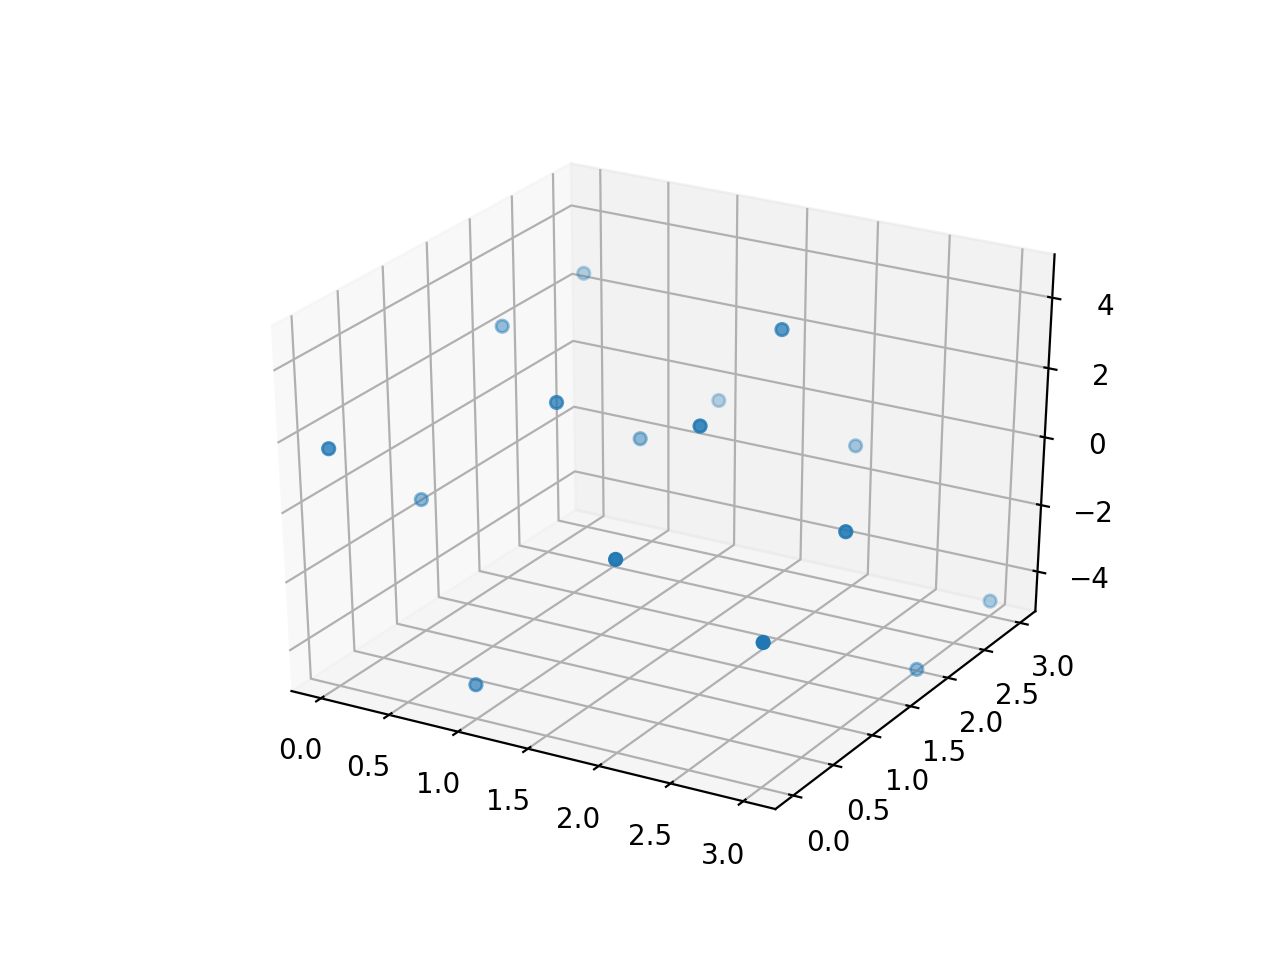

In [3]:
grid_size = (4, 4)
indices = np.indices(grid_size)

row_idx = indices[0]
col_idx = indices[1]
height = np.random.normal(0, 3, grid_size)
grid = np.stack((row_idx, col_idx, height), axis=-1)
xs, ys, zs = np.split(grid, 3, axis=-1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlim3d(-5, 5)
ax.scatter(xs, ys, zs)

# Draw curves on points (not quite a surface yet!)

<IPython.core.display.Javascript object>


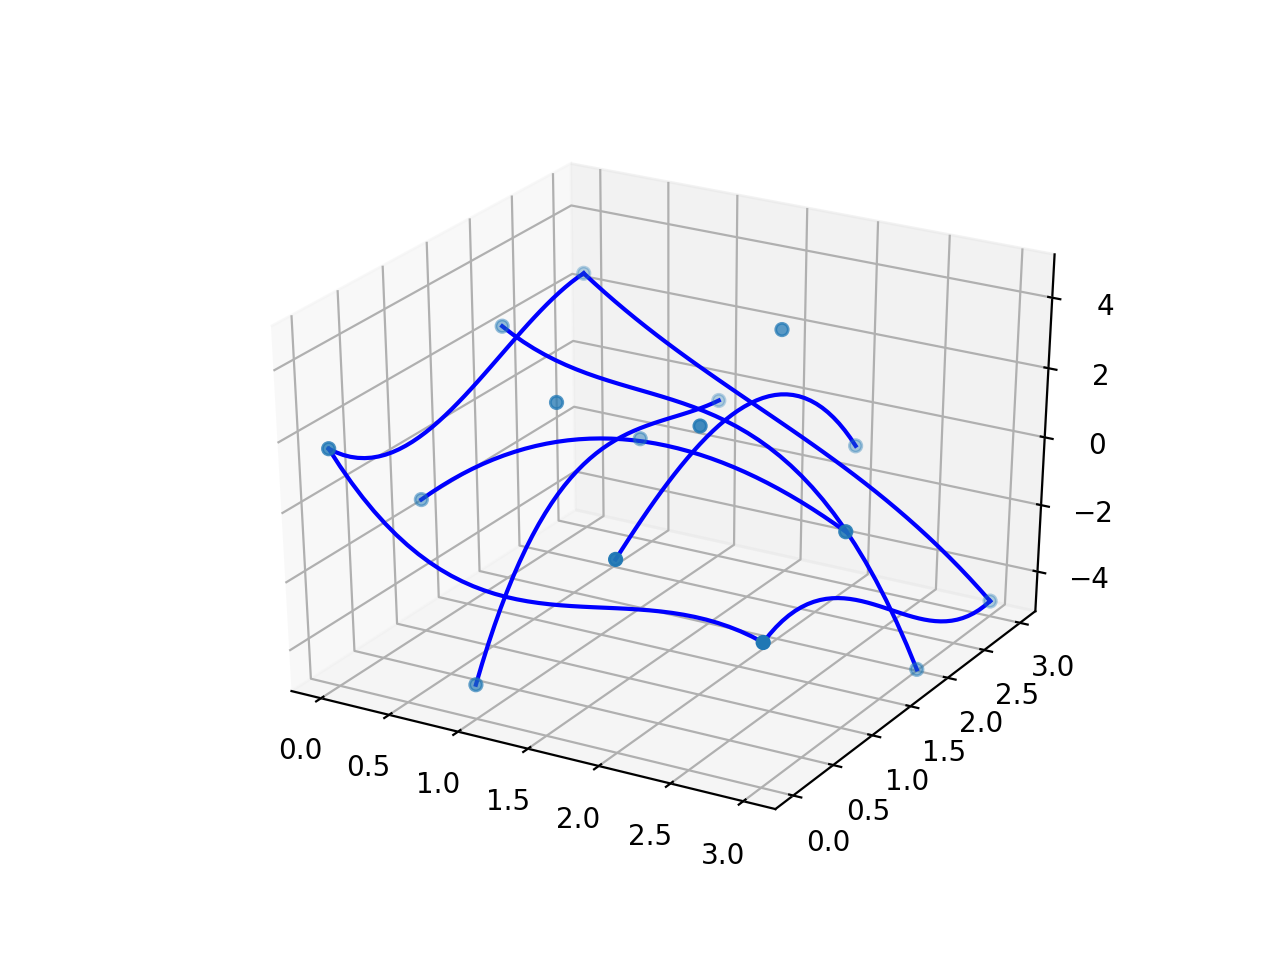

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlim3d(-5, 5)

samples = 40 
t = np.linspace(0, 1, samples) 
surface = np.zeros((samples, samples))
step = samples / grid_size[0]

for y, row in enumerate(grid):
    curve = bezier_curve(row.T, t)
    xsc, ysc, zsc = np.squeeze(np.split(curve, 3, axis=0))
    ax.plot3D(xsc, ysc, zsc, c='b')
    
# Swap x and y axis for easy column iterating
grid_t = np.transpose(grid, (1, 0, 2))
for x, column in enumerate(grid_t):
    curve = bezier_curve(column.T, t)
    xsc, ysc, zsc = np.squeeze(np.split(curve, 3, axis=0))
    ax.plot3D(xsc, ysc, zsc, c='b')

# xsc, ysc, zsc = np.squeeze(np.split(curve, 3, axis=0))

ax.scatter(xs, ys, zs)

# ax.plot3D(xsc[:], ysc[:], zsc[:])

# Bezier Surface

We will use the explicit definition of the bezier curve. 
A Bezier surface can be defined as the product of two bernstein polynomials and control points.
$$p(u,v)=\sum _{{i=0}}^{n}\sum _{{j=0}}^{m}B_{i}^{n}(u)\;B_{j}^{m}(v)\;{\mathbf  {k}}_{{i,j}}$$

I read this formula in the following way: 
The surface is affected by every control point $k_{i,j}$. The degree to which these control points influence areas of the surface depends on the point's Bernstein polynomial at that area, $B(u)$ or $B(v)$.

\begin{aligned}\mathbf {B} (t)&=\sum _{i=0}^{n}{n \choose i}(1-t)^{n-i}t^{i}\mathbf {P} _{i}\\&=(1-t)^{n}\mathbf {P} _{0}+{n \choose 1}(1-t)^{n-1}t\mathbf {P} _{1}+\cdots +{n \choose n-1}(1-t)t^{n-1}\mathbf {P} _{n-1}+t^{n}\mathbf {P} _{n}&&0\leqslant t\leqslant 1\end{aligned}

As seen above, the surface formula is not parameterized by a single variable $t$ with range $[0,1]$.  
Instead, there are two, $u$ and $v$. This could be understood as mapping a unit square to the bezier surface (each point on the Bezier surface is associated with a point on the unit square). 
     
According to the definition of the surface and the bernstein polynomial, it matters in which order the points occur (i.e. which $i$ and $j$ are assigned to control points). To ensure a surface does not intersect itself, we can order the control points in ascending order along $u$ and $v$. 

<IPython.core.display.Javascript object>


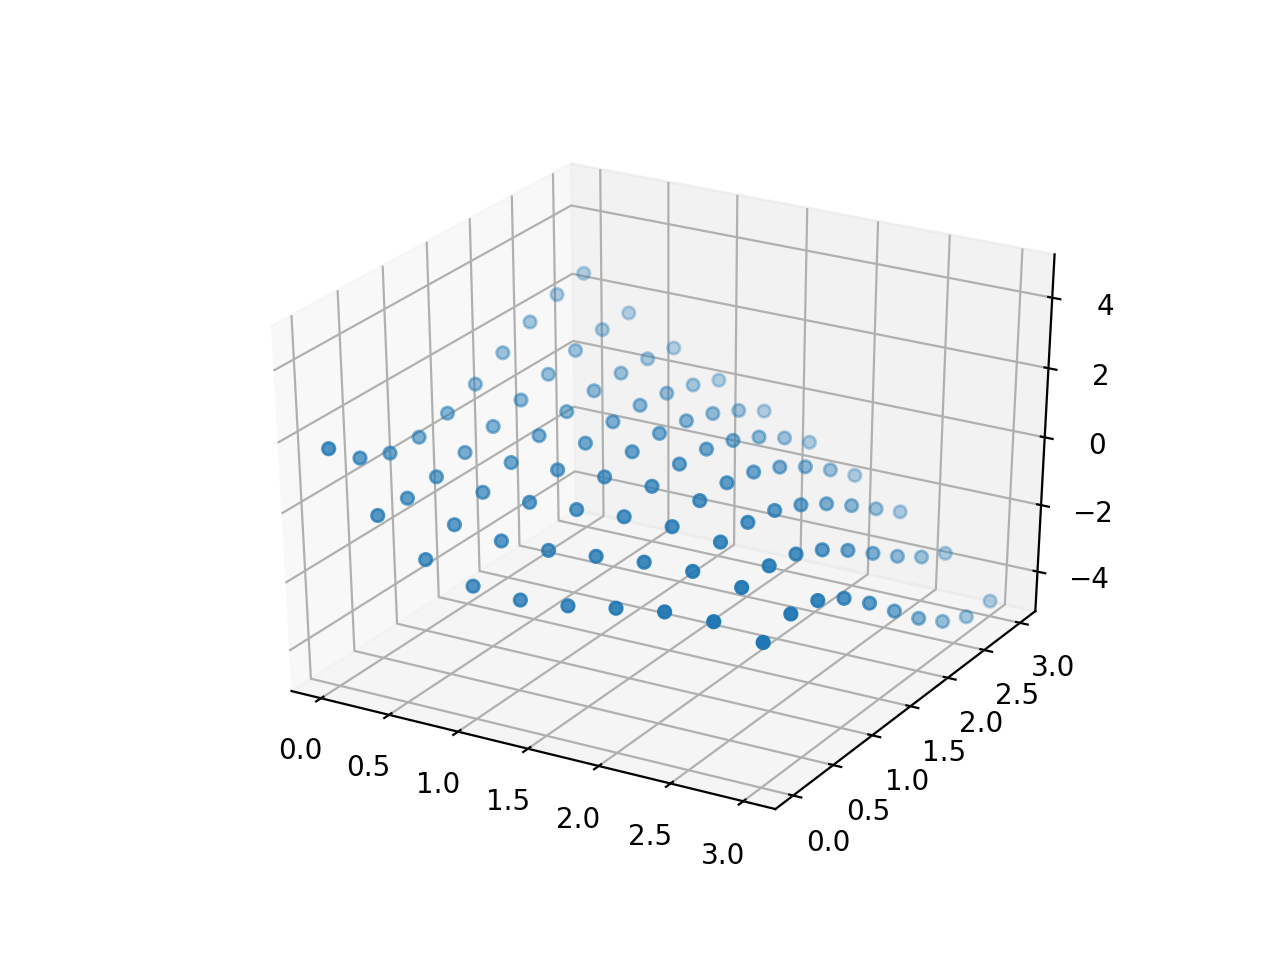

In [5]:
def bernstein_polynomail(i, n, t):
    binomial = binom(n, i)
    return binomial * ((1 - t)**(n - i))  * (t**i)

u = np.linspace(0, 1, 10)
v = np.linspace(0, 1, 10)
# Get cartesian product of coordinates u and v
meshgrid = np.array(np.meshgrid(u, v)).T.reshape((-1, 2))
u = meshgrid[:, 0]
v = meshgrid[:, 1]
n = 4 - 1

influences = list()
for y, row in enumerate(grid): 
    for x, vector in enumerate(row):
        
        b_u = bernstein_polynomail(x, n, u)
        b_v = bernstein_polynomail(y, n, v)
        
        point_influence = np.tensordot(vector, (b_u * b_v), axes=0)
        influences.append(point_influence)

influences = np.array(influences)
influences.shape

curve = influences.sum(axis=0)
xsc, ysc, zsc = np.squeeze(np.split(curve, 3, axis=0))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlim3d(-5, 5)
ax.scatter(xsc, ysc, zsc)

# Plot points as surface

<IPython.core.display.Javascript object>


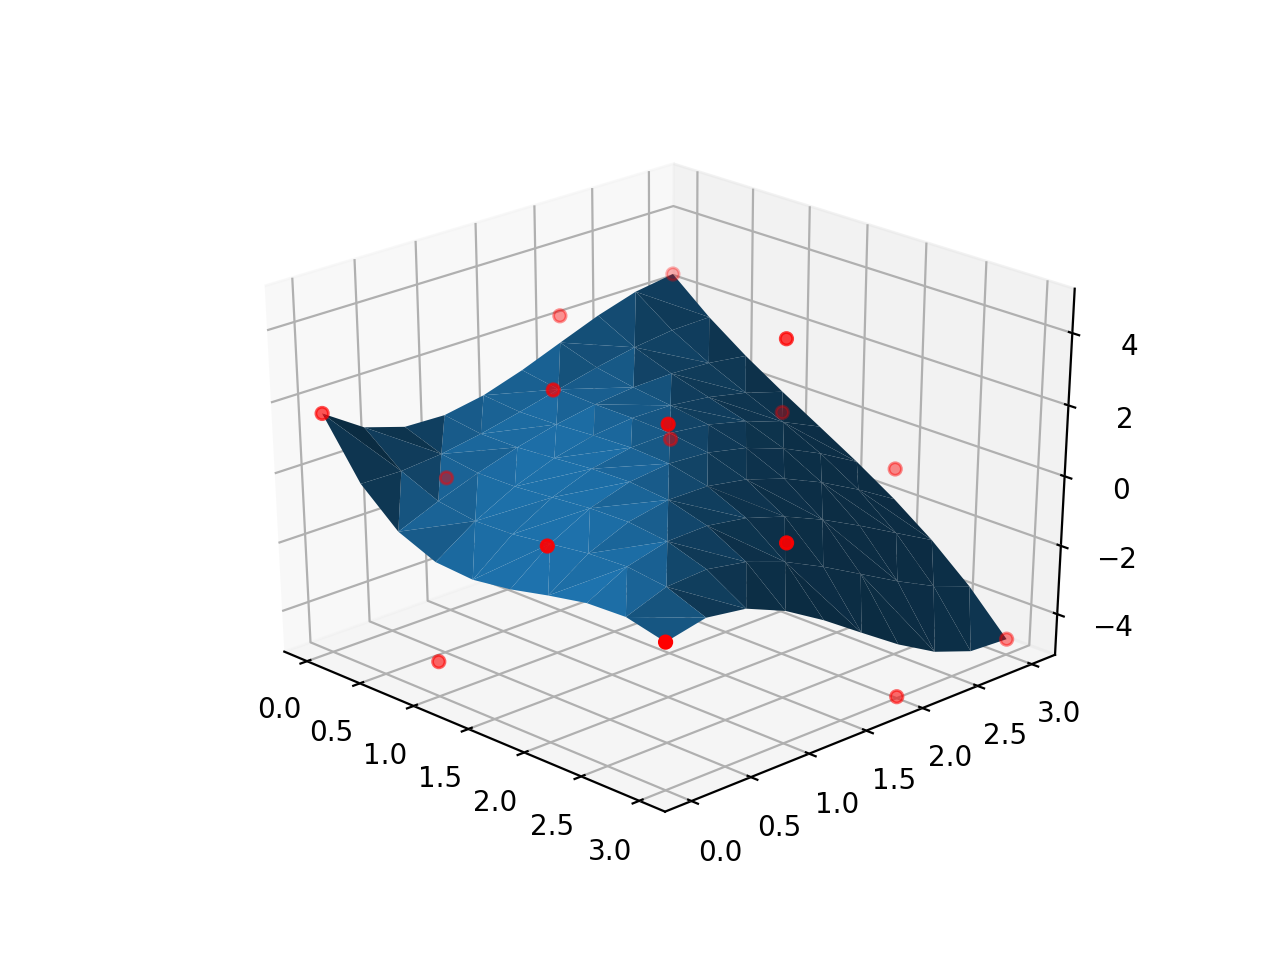

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlim3d(-5, 5)
ax.plot_trisurf(xsc, ysc, zsc, linewidth=0)

# Control points
xs, ys, zs = np.split(grid, 3, axis=-1)
ax.scatter(xs, ys, zs, c='r')
fig.savefig('plot.png')